In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from functools import partial

import jax
import jax.numpy as jnp

# from potential_cylspline import *
from constants import *

from cubic_spline import *

def mn_phi_cyl(R, z, M, a, b, G):
    """
    Miyamoto–Nagai potential Φ(R,z) = - G M / sqrt(R^2 + (a + sqrt(z^2 + b^2))^2)
    """
    R = np.asarray(R, float); z = np.asarray(z, float)
    beta = np.sqrt(z*z + b*b)
    D = np.sqrt(R*R + (a + beta)**2)
    return -G * M / D

def mn_rho_cyl(R, z, M, a, b):
    """
    Miyamoto–Nagai density ρ(R,z) from the analytic potential–density pair.
    ρ = (b^2 M / 4π) * [ a R^2 + (a + 3β)(a + β)^2 ] / [ β^3 * (R^2 + (a + β)^2)^(5/2) ],
    where β = sqrt(z^2 + b^2).
    """
    R = np.asarray(R, float); z = np.asarray(z, float)
    beta = np.sqrt(z*z + b*b)
    D2 = R*R + (a + beta)**2
    num = a * R*R + (a + 3.0*beta) * (a + beta)**2
    den = (beta**3) * (D2**2.5)
    return (b*b * M / (4.0 * np.pi)) * (num / den)

def mn_phi_cart(x, y, z, M=1e9, a=3, b=0.8, G=4.3e-6):
    x = np.asarray(x, float); y = np.asarray(y, float); z = np.asarray(z, float)
    R = np.sqrt(x*x + y*y)
    return mn_phi_cyl(R, z, M=M, a=a, b=b, G=G)

def mn_rho_cart(x, y, z, M=1e9, a=3, b=0.8):
    x = np.asarray(x, float); y = np.asarray(y, float); z = np.asarray(z, float)
    R = np.sqrt(x*x + y*y)
    return mn_rho_cyl(R, z, M=M, a=a, b=b)

In [2]:
import time as tt

start = tt.time()
HYPERGEOM_0[0]
end = tt.time()
print("Numpy time:", 1000*(end - start))

start = tt.time()
HYPERGEOM_1[0]
end = tt.time()
print("Numpy time:", 1000*(end - start))

Numpy time: 19.418954849243164
Numpy time: 14.683008193969727


In [3]:
def mn_rho_cyl(R, z, M, a, b):
    """
    Miyamoto–Nagai density ρ(R,z) from the analytic potential–density pair.
    ρ = (b^2 M / 4π) * [ a R^2 + (a + 3β)(a + β)^2 ] / [ β^3 * (R^2 + (a + β)^2)^(5/2) ],
    where β = sqrt(z^2 + b^2).
    """
    beta = jnp.sqrt(z*z + b*b)
    D2 = R*R + (a + beta)**2
    num = a * R*R + (a + 3.0*beta) * (a + beta)**2
    den = (beta**3) * (D2**2.5)
    return (b*b * M / (4.0 * jnp.pi)) * (num / den)

@jax.jit
def rho_xyz(x,y,z):
    R = jnp.sqrt(x*x + y*y)
    return mn_rho_cyl(R, z, M=1e9, a=3, b=0.8)

@jax.jit
def cylindrical_to_cartesian(R, phi, z):
    x = R * jnp.cos(phi)
    y = R * jnp.sin(phi)
    return x, y, z

@jax.jit
def rho_Rzphi(R, z, phi):
    z = jnp.abs(z)  # even symmetry
    x, y, zz = cylindrical_to_cartesian(R, phi, z)
    return rho_xyz(x, y, zz)

@jax.jit
def rho_last(R, z, m, phi, Nphi=200):
    dphi = (2*jnp.pi) / Nphi
    vals = rho_Rzphi(R, z, phi)
    exp_ph = jnp.exp(-1j * m * phi)
    rho_m_stack = vals * exp_ph * dphi / (2.0 * jnp.pi)
    return rho_m_stack

@jax.jit
def rho_phiZRm(R, z, m, phi):
    return jnp.sum(jax.vmap(rho_last, in_axes=(None, None, None, 0))(R, z, m, phi), axis=0)

@jax.jit
def compute_rho_m(R, z, m, phi):
    return jax.vmap(rho_phiZRm, in_axes=(None, None, 0, None))(R, z, m, phi)

In [4]:
# NR, NZ, Rmin, Rmax, Zmin, Zmax, Mmax = 30, 30, 1e-3, 20., 1e-3, 10., 8. 
NR, NZ, Rmin, Rmax, Zmin, Zmax, Mmax = 50, 30, 1e-2, 30.0, 1e-2, 20.0, 0

Nphi = 200

M = jnp.arange(0, Mmax + 1)

R = jnp.geomspace(jnp.maximum(Rmin, 1e-3), Rmax, NR)
R0_eff = R[NR // 2]

Zpos = jnp.geomspace(jnp.maximum(Zmin, 1e-3), Zmax, NZ)
Z_nonneg = jnp.concatenate([jnp.array([0.0]), Zpos])

Rg, Zg = jnp.meshgrid(R, Z_nonneg, indexing="ij")
phi = jnp.linspace(0.0, 2*jnp.pi, Nphi, endpoint=False)

dphi = (2*jnp.pi) / Nphi

rho_m = jax.vmap(compute_rho_m, in_axes=(0, 0, None, None))(Rg, Zg, M, phi).transpose(1,0,2) 

In [5]:
# import scipy.interpolate as interpax

test_points = np.array([
    np.random.uniform(1, 4, 100),
    np.random.uniform(1, 3, 100)
]).T
    
rho_real = jnp.zeros((len(M), len(R), len(Z_nonneg)))
rho_img = jnp.zeros((len(M), len(R), len(Z_nonneg)))
Mx_real = jnp.zeros((len(M), len(R), len(Z_nonneg)))
My_real = jnp.zeros((len(M), len(R), len(Z_nonneg)))
Mx_img = jnp.zeros((len(M), len(R), len(Z_nonneg)))
My_img = jnp.zeros((len(M), len(R), len(Z_nonneg)))
for m in M.astype(int):
    rho_real = rho_real.at[m].set(rho_m[m].real)
    M_x, M_y = jax_precompute_splines((R, Z_nonneg), rho_m[m].real)
    Mx_real = Mx_real.at[m].set(M_x)
    My_real = My_real.at[m].set(M_y)
    rho_img = rho_img.at[m].set(rho_m[m].imag)
    M_x, M_y = jax_precompute_splines((R, Z_nonneg), rho_m[m].imag)
    Mx_img = Mx_img.at[m].set(M_x)
    My_img = My_img.at[m].set(M_y)

# @partial(jax.jit, static_argnums=(0,))
def jax_rho_m_eval(m, R, z, Rgrid, Zgrid, rho_real, rho_img, Mx_real, My_real, Mx_img, My_img):
    real_values = rho_real[m]
    imag_values = rho_img[m]
    M_x_real = Mx_real[m]
    M_y_real = My_real[m]
    M_x_imag = Mx_img[m]
    M_y_imag = My_img[m]

    shape = R.shape
    pts = jnp.column_stack((R.ravel(), jnp.abs(z).ravel()))

    real_part = cubic_spline_evaluate(pts, (Rgrid, Zgrid), real_values, M_x_real, M_y_real, fill_value=0.0).reshape(shape)
    imag_part = cubic_spline_evaluate(pts, (Rgrid, Zgrid), imag_values, M_x_imag, M_y_imag, fill_value=0.0).reshape(shape)

    return real_part + 1j * imag_part


In [6]:
@jax.jit
def jax_hypergeom_m(m, x):
    """
    m: int,
    x: array-like
    """


    y = 1.0 - x
    y2 = y*y
    z = jnp.log(jnp.where(y > 1e-12, y, 1e-12))

    HYPERGEOM_0_m = HYPERGEOM_0[m]
    HYPERGEOM_I_m = HYPERGEOM_I[m]
    HYPERGEOM_1_m = HYPERGEOM_1[m]

    xA8_1 = x + HYPERGEOM_0_m[8]
    xA6_1 = x + HYPERGEOM_0_m[6] + HYPERGEOM_0_m[7] / xA8_1
    xA4_1 = x + HYPERGEOM_0_m[4] + HYPERGEOM_0_m[5] / xA6_1
    xA2_1 = x + HYPERGEOM_0_m[2] + HYPERGEOM_0_m[3] / xA4_1
    val_1 = HYPERGEOM_0_m[0] + HYPERGEOM_0_m[1] / xA2_1

    xA8_2 = x + HYPERGEOM_I_m[8]
    xA6_2 = x + HYPERGEOM_I_m[6] + HYPERGEOM_I_m[7] / xA8_2
    xA4_2 = x + HYPERGEOM_I_m[4] + HYPERGEOM_I_m[5] / xA6_2
    xA2_2 = x + HYPERGEOM_I_m[2] + HYPERGEOM_I_m[3] / xA4_2
    val_2 = HYPERGEOM_I_m[0] + HYPERGEOM_I_m[1] / xA2_2

    val3 = (HYPERGEOM_1_m[0] + HYPERGEOM_1_m[1]*z +
             (HYPERGEOM_1_m[2] + HYPERGEOM_1_m[3]*z) * y +
             (HYPERGEOM_1_m[4] + HYPERGEOM_1_m[5]*z + 
             (HYPERGEOM_1_m[6] + HYPERGEOM_1_m[7]*z) * y + 
             (HYPERGEOM_1_m[8] + HYPERGEOM_1_m[9]*z) * y2) * y2)

    F = jnp.where(x < X_THRESHOLD1[m],
                 jnp.where(x < X_THRESHOLD0[m], val_1, val_2),
                 val3)

    return F

@jax.jit
def jax_legendreQ(n, x):
    """
    n: float,
    x: array-like
    """

    x = jnp.where(x < 1.0, 1.0, x)
    out = jnp.empty_like(x)
    m = jnp.round(n + 0.5).astype(jnp.int32)

    pref = Q_PREFACTOR[m] / jnp.sqrt(x) / (x**m)
    F = jax_hypergeom_m(m, 1.0/(x*x))
    out = pref * F

    return out

@jax.jit
def jax_kernel_Xi_m(m, R, z, Rp, zp):

    """
    m: int,
    R: float,
    z: float,
    Rp: array-like,
    zp: array-like
    """
    zeros = jnp.zeros_like(Rp, dtype=float)

    val1 = zeros
    val2 = 1.0 / jnp.sqrt(R*R + Rp*Rp + (z - zp)**2)

    val_zero = jax.lax.cond(m>0, lambda: val1, lambda: val2)
    
    Rp_reg = Rp
    dz = (z - zp)
    chi = (R*R + Rp_reg*Rp_reg + dz*dz) / (2.0 * R * Rp_reg)
    chi = jnp.maximum(chi, 1.0)
    Q = jax_legendreQ(m - 0.5, chi)
    val_nonzero = (1.0 / (jnp.pi * jnp.sqrt(R * Rp_reg))) * Q


    val_out = jnp.where(Rp<1e-3, val_zero, val_nonzero)

    out = jax.lax.cond(R < 1e-3, lambda: val_zero, lambda: val_out)

    return out

In [7]:
### Now for Compute the Potential components

N_int = 10_000
base = jnp.maximum(9, jnp.sqrt(jnp.maximum(16, N_int)).astype(int))
base += jnp.abs(base % 2 - 1)  # make it odd

n_xi = base
n_eta = base

@partial(jax.jit, static_argnames=['n'])
def simpson_weights(n):
    w = jnp.ones(n)
    w = w.at[1:-1:2].set(4.0)
    w = w.at[2:-1:2].set(2.0)
    w *= (1.0 / (n - 1)) / 3.0   # h = 1/(n-1), scale by h/3
    return w

wxi  = simpson_weights(int(n_xi))
weta = simpson_weights(int(n_eta))

xi  = jnp.linspace(0.0, 1.0, n_xi)
eta = jnp.linspace(0.0, 1.0, n_eta)
XI, ETA = jnp.meshgrid(xi, eta, indexing="ij")

@jax.jit
def _xieta_to_Rz_jacobian(xi, eta, Rzminmax):
    # Rmin_map = R[1]
    # Rmax_map = Rmax
    # zmin_map = Z_nonneg[1]
    # zmax_map = Zmax
    Rmin_map = Rzminmax[0]
    Rmax_map = Rzminmax[1]
    zmin_map = Rzminmax[2]
    zmax_map = Rzminmax[3]

    # Precompute logs
    LR = jnp.log(1.0 + Rmax_map / Rmin_map)
    LZ = jnp.log(1.0 + zmax_map / zmin_map)

    # Map to physical coordinates
    pR = jnp.power(1.0 + Rmax_map / Rmin_map, xi)
    pZ = jnp.power(1.0 + zmax_map / zmin_map, eta)
    Rp = Rmin_map * (pR - 1.0)
    zp = zmin_map * (pZ - 1.0)

    # Jacobian part from the coordinate transform (no 2πR' here)
    dR_dxi  = LR * (Rmin_map + Rp)
    dz_deta = LZ * (zmin_map + zp)
    J = dR_dxi * dz_deta
    return Rp, zp, J

Rp, zp, Jmap = _xieta_to_Rz_jacobian(XI, ETA, jnp.array([R[1], Rmax, Z_nonneg[1], Zmax])) 
W2D = jnp.einsum('i,j->ij', wxi, weta)

m_list = jnp.array(M)

In [8]:
# @jax.jit
def m_wrapper(m, R0, z0, Rp, zp):
    rho_grid = jax_rho_m_eval(m.astype(int), Rp, zp, R, Z_nonneg, rho_real, rho_img, Mx_real, My_real, Mx_img, My_img)

    return jax.vmap(R_wrapper, in_axes=(None, 0, None, None, None, None))(m, R0, z0, Rp, zp, rho_grid)

@jax.jit
def R_wrapper(m, R0, z0, Rp, zp, rho_grid):
    return jax.vmap(Z_wrapper, in_axes=(None, None, 0, None, None, None))(m, R0, z0, Rp, zp, rho_grid)

@jax.jit
def Z_wrapper(m, R0, z0, Rp, zp, rho_grid):
    Xi_plus  = jax_kernel_Xi_m(m, R0, z0, Rp, zp)
    Xi_minus = jax_kernel_Xi_m(m, R0, z0, Rp, -zp)
    Xi_sum   = Xi_plus + Xi_minus

    F = rho_grid * Xi_sum * (2.0 * np.pi) * Rp * Jmap

    I = np.sum(W2D * F)

    return -G * I

phi_m = jax.vmap(m_wrapper, in_axes=(0, None, None, None, None))(M.astype(int), R, Z_nonneg, Rp, zp)

In [9]:
phi_real = jnp.zeros((len(M), len(R), len(Z_nonneg)))
phi_img = jnp.zeros((len(M), len(R), len(Z_nonneg)))
phi_Mx_real = jnp.zeros((len(M), len(R), len(Z_nonneg)))
phi_My_real = jnp.zeros((len(M), len(R), len(Z_nonneg)))
phi_Mx_img = jnp.zeros((len(M), len(R), len(Z_nonneg)))
phi_My_img = jnp.zeros((len(M), len(R), len(Z_nonneg)))
for m in M.astype(int):
    phi_real = phi_real.at[m].set(phi_m[m].real)
    M_x, M_y = jax_precompute_splines((R, Z_nonneg), phi_m[m].real)
    phi_Mx_real = phi_Mx_real.at[m].set(M_x)
    phi_My_real = phi_My_real.at[m].set(M_y)
    phi_img = phi_img.at[m].set(phi_m[m].imag)
    M_x, M_y = jax_precompute_splines((R, Z_nonneg), phi_m[m].imag)
    phi_Mx_img = phi_Mx_img.at[m].set(M_x)
    phi_My_img = phi_My_img.at[m].set(M_y)


In [10]:
def jax_phi_m_eval(m, x, y, z, Rgrid, Zgrid, rho_real, rho_img, Mx_real, My_real, Mx_img, My_img):

    R, ph = jnp.sqrt(x*x + y*y), jnp.arctan2(y, x)
    real_values = rho_real[m]
    imag_values = rho_img[m]
    M_x_real = Mx_real[m]
    M_y_real = My_real[m]
    M_x_imag = Mx_img[m]
    M_y_imag = My_img[m]

    shape = R.shape
    pts = jnp.column_stack((R.ravel(), jnp.abs(z).ravel()))

    real_part = cubic_spline_evaluate(pts, (Rgrid, Zgrid), real_values, M_x_real, M_y_real, fill_value=0.0).reshape(shape)
    imag_part = cubic_spline_evaluate(pts, (Rgrid, Zgrid), imag_values, M_x_imag, M_y_imag, fill_value=0.0).reshape(shape)

    phi_m = real_part + 1j * imag_part

    return (phi_m.real * jnp.cos(m*ph) - phi_m.imag * jnp.sin(m*ph))

In [11]:
def get_pot_from_coord(x,y,z):
    phi_grid = jax.vmap(jax_phi_m_eval, in_axes=(0, None, None, None, None, None, None, None, None, None, None, None))(
        M.astype(int), x, y, z, R, Z_nonneg, phi_real, phi_img, phi_Mx_real, phi_My_real, phi_Mx_img, phi_My_img)
    return jnp.sum(phi_grid, axis=0)

100%|██████████| 100/100 [00:00<00:00, 164.47it/s]


(array([ 36.,  20.,  44.,  44.,  40.,  44.,  48.,  48.,  52.,  52.,  56.,
         64.,  56.,  72.,  64.,  64.,  76.,  52.,  92.,  88.,  76.,  84.,
         84.,  96.,  72., 108.,  96.,  96., 112., 120.,  88., 120., 116.,
        104., 116., 136., 116., 140., 136., 128., 136., 136., 140., 148.,
        128., 152., 144., 160., 164., 144., 172., 160., 156., 172., 164.,
        156., 188., 172., 176., 196., 180., 160., 184., 160., 136., 176.,
        164., 156., 164., 168., 136., 168., 120., 124., 112., 116.,  96.,
        100.,  88.,  88.,  76.,  68.,  60.,  68.,  64.,  60.,  56.,  48.,
         44.,  44.,  28.,  24.,  32.,  28.,  24.,  20.,  16.,  12.,   8.,
          4.]),
 array([1.01027513, 1.01048958, 1.01070392, 1.01091838, 1.01113272,
        1.01134717, 1.01156163, 1.01177597, 1.01199043, 1.01220477,
        1.01241922, 1.01263368, 1.01284802, 1.01306248, 1.01327682,
        1.01349127, 1.01370573, 1.01392007, 1.01413453, 1.01434886,
        1.01456332, 1.01477778, 1.01499212, 1.

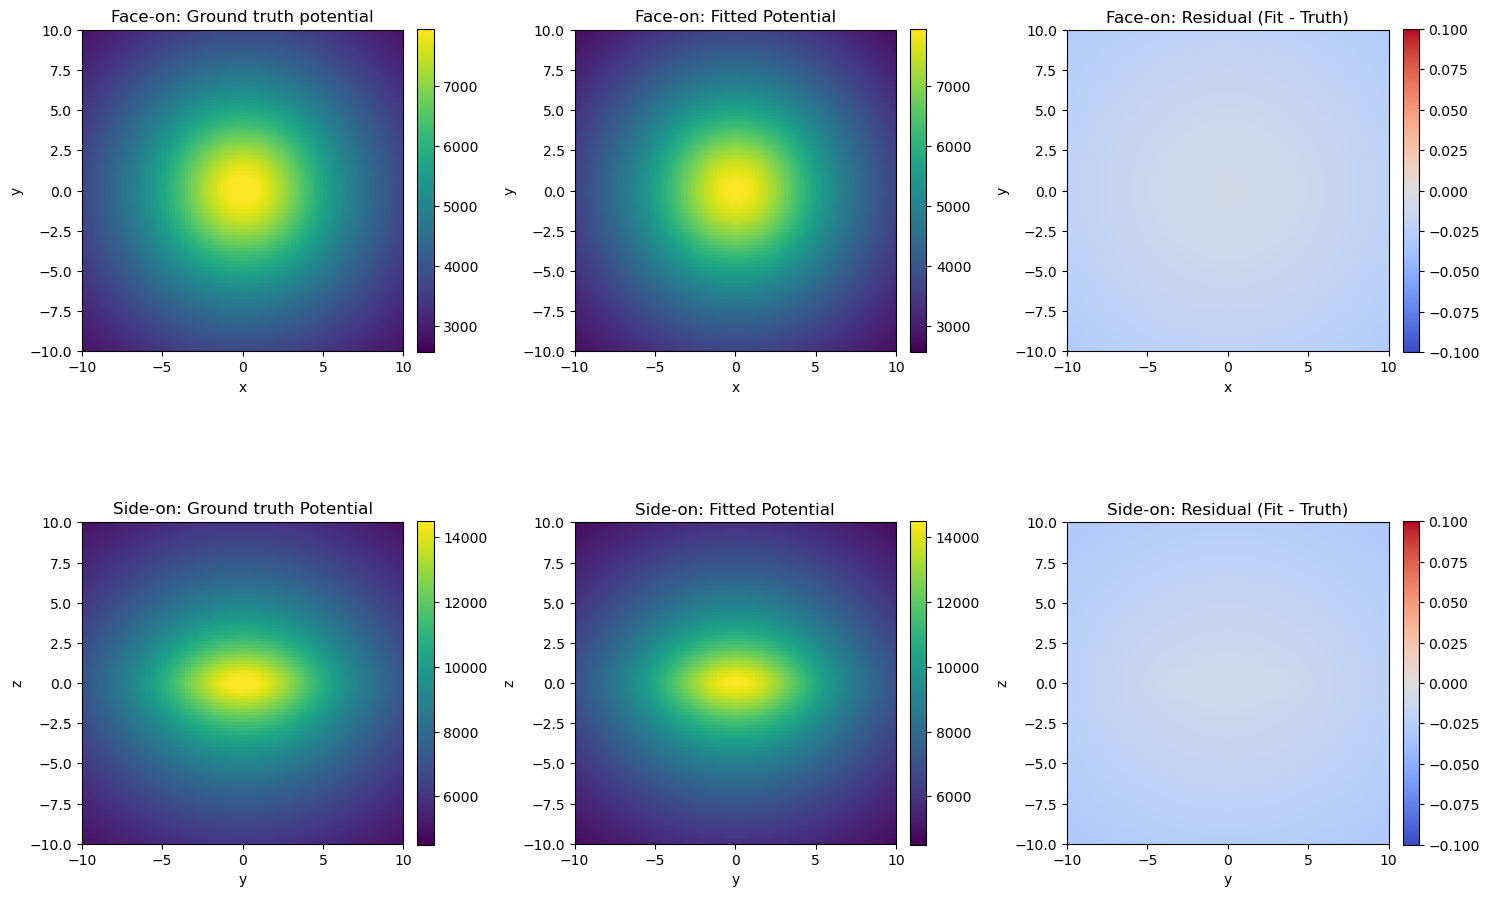

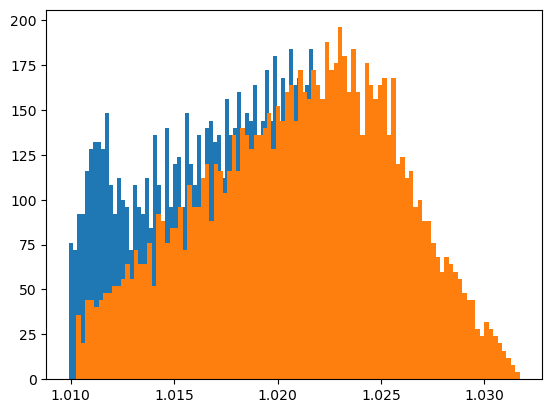

In [13]:
def Phi_gt(pts):
    x, y, z = pts[:,0], pts[:,1], pts[:,2]
    return mn_phi_cart(x, y, z)

from tqdm import tqdm

nx = 100
x = np.linspace(-10, 10, nx)
y = np.linspace(-10, 10, nx)
X, Y = np.meshgrid(x, y)
Z = np.linspace(-5, 5, nx)
dZ = Z[1] - Z[0]
Y2 = np.linspace(-10, 10, nx)
Z2 = np.linspace(-10, 10, nx)
Yg, Zg = np.meshgrid(Y2, Z2)
X2 = np.linspace(-10, 10, nx)
# X2 = np.array([-0.1,0.1])#np.linspace(-10, 10, nx)
dX = X2[1] - X2[0]


Potential_agama_faceon = np.zeros_like(X)
for i in tqdm(range(len(Z))):

    z_slice = Z[i]
    # r, th, ph = cart_to_sph(np.full_like(Yg, x_slice), Yg, Zg)
    points = np.column_stack((X.ravel(), Y.ravel(), np.full_like(X.ravel(), z_slice)))
    Potential_agama_faceon += (Phi_gt(points) * dZ).reshape(X.shape)

Potential_fit_faceon = np.zeros_like(X)
for i in tqdm(range(len(Z))):
    z_slice = Z[i]
    Potential_fit_faceon += (get_pot_from_coord(X, Y, np.full_like(X, z_slice)) * dZ)
# for i in tqdm(range(len(Z))):
#     z_slice = Z[i]
#     points = np.column_stack((X.ravel(), Y.ravel(), np.full_like(X.ravel(), z_slice)))
#     Potential_fit_faceon += (pot_agama.potential(points) * dZ).reshape(X.shape)


Potential_agama_sideon = np.zeros_like(Yg)
for i in tqdm(range(len(X2))):
    x_slice = X2[i]
    # r, th, ph = cart_to_sph(np.full_like(Yg, x_slice), Yg, Zg)
    points = np.column_stack((np.full_like(Yg.ravel(), x_slice), Yg.ravel(), Zg.ravel()))
    Potential_agama_sideon += (Phi_gt(points) * dX).reshape(Yg.shape)

Potential_fit_sideon = np.zeros_like(Yg)
for i in tqdm(range(len(X2))):
    x_slice = X2[i]
    Potential_fit_sideon += (get_pot_from_coord(np.full_like(Yg, x_slice), Yg, Zg) * dX)
# for i in tqdm(range(nx)):
#     x_slice = X2[i]
#     points = np.column_stack((np.full_like(Yg.ravel(), x_slice), Yg.ravel(), Zg.ravel()))
#     Potential_fit_sideon += (pot_agama.potential(points) * dX).reshape(Yg.shape)

# Residual (side-on)
Potential_residual_faceon = Potential_fit_faceon - Potential_agama_faceon
Potential_residual_sideon = Potential_fit_sideon - Potential_agama_sideon

# --- Plotting ---
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

vmin = np.min([-Potential_agama_faceon.min(), -Potential_fit_faceon.min()])
vmax = np.max([-Potential_agama_faceon.max(), -Potential_fit_faceon.max()])
# Face-on
im0 = axs[0, 0].imshow(-Potential_agama_faceon, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], cmap='viridis',
vmin=vmin, vmax=vmax)
axs[0, 0].set_title('Face-on: Ground truth potential')
plt.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)

im1 = axs[0, 1].imshow(-Potential_fit_faceon, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], cmap='viridis',
vmin=vmin, vmax=vmax)
axs[0, 1].set_title('Face-on: Fitted Potential')
plt.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)

im2 = axs[0, 2].imshow(Potential_residual_faceon/Potential_agama_faceon, origin='lower', 
extent=[x.min(), x.max(), y.min(), y.max()], cmap='coolwarm', vmin=-0.1, vmax=0.1)
axs[0, 2].set_title('Face-on: Residual (Fit - Truth)')
plt.colorbar(im2, ax=axs[0, 2], fraction=0.046, pad=0.04)

for ax in axs[0, :]:
    ax.set_xlabel('x')
    ax.set_ylabel('y')

# Side-on
vmin = np.min([-Potential_agama_sideon.min(), -Potential_fit_sideon.min()])
vmax = np.max([-Potential_agama_sideon.max(), -Potential_fit_sideon.max()])
im3 = axs[1, 0].imshow(-Potential_agama_sideon, origin='lower', extent=[Y2.min(), Y2.max(), Z2.min(), Z2.max()], cmap='viridis',
vmin=vmin, vmax=vmax)
axs[1, 0].set_title('Side-on: Ground truth Potential')
plt.colorbar(im3, ax=axs[1, 0], fraction=0.046, pad=0.04)

im4 = axs[1, 1].imshow(-Potential_fit_sideon, origin='lower', extent=[Y2.min(), Y2.max(), Z2.min(), Z2.max()], cmap='viridis',
vmin=vmin, vmax=vmax)
axs[1, 1].set_title('Side-on: Fitted Potential')
plt.colorbar(im4, ax=axs[1, 1], fraction=0.046, pad=0.04)

im5 = axs[1, 2].imshow(Potential_residual_sideon/Potential_agama_sideon, origin='lower',
extent=[Y2.min(), Y2.max(), Z2.min(), Z2.max()], cmap='coolwarm', vmin=-0.1, vmax=0.1)
axs[1, 2].set_title('Side-on: Residual (Fit - Truth)')
plt.colorbar(im5, ax=axs[1, 2], fraction=0.046, pad=0.04)

for ax in axs[1, :]:
    ax.set_xlabel('y')
    ax.set_ylabel('z')

plt.tight_layout()


plt.figure()
plt.hist((Potential_agama_faceon/Potential_fit_faceon).ravel(), bins = 100)
plt.hist((Potential_agama_sideon/Potential_fit_sideon).ravel(), bins = 100)